# Explore here

In [1]:
from utils import db_connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:

# Establecer la conexión a la base de datos
engine = db_connect()

# Verificar si la conexión es exitosa
#if engine:
    #print("Conexión exitosa")

# Consultar la tabla en la base de datos y crear un DataFrame
data = pd.read_sql_table('2019-ABNB', engine)

pd.set_option('display.max_columns', None)  # muestra todas las columnas del dataframe
data.head()



,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,None,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
# Mostrar informacion sobre el dataframe
data.shape
data.info()

# En principio vemos que las columna id, host_id se pueden eliminar

# host_name tambien se puede eliminar, ya que de entre todos los anuncios listados (48895), 48874 son distintos, es decir,
#  * solo hay 21 inmuebles que podrían tener el mismo propietario, 0,04% de la muestra. Por tanto, podemos predecir ya que la identidad del propietario no tiene mayor impacto en la cuestion.

# En cuanto a la columna 'name', que vemos que contiene una pequeña descripción, nos encontramos en una situacion parecida, sin embargo,
#  * puesto que se trata de un pequeño 'titular', podemos pensar que no tiene relacion con el precio, pero si es posible que este titular tenga
#  * impacto sobre la demanda, lo que tiene impacto en el precio. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [4]:

data[['name', 'number_of_reviews', 'price', 'reviews_per_month', 'calculated_host_listings_count']]

# Estudiando las columnas en conjunto podemos concluir que la columna 'name', no tendra practicamente interés para el modelo,
#  * ya que no oferce informacion relevante y a simplpe vista no parece tener correlacion entre el precio y el numero de visitas.
# Además, sabiendo el mercado del que se trata, es decir inmuebles turísticos de Airbnb, podemos concluír que a la hora de hacer una búsqueda
#  * de alojamiento, el precio y la situación son las principales variables, y que el nombre apenas tiene interés ni llamada al 'click',
#  * y que en todo caso seria da descripcion detallada y sobre todo las fotografía lo que podría inclinar la balanza de la demanda.



,name,number_of_reviews,price,reviews_per_month,calculated_host_listings_count
0,Clean & quiet apt home by the park,9,149,0.21,6
1,Skylit Midtown Castle,45,225,0.38,2
2,THE VILLAGE OF HARLEM....NEW YORK !,0,150,NaN,1
3,Cozy Entire Floor of Brownstone,270,89,4.64,1
4,Entire Apt: Spacious Studio/Loft by central park,9,80,0.10,1
...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,0,70,NaN,2
48891,Affordable room in Bushwick/East Williamsburg,0,40,NaN,2
48892,Sunny Studio at Historical Neighborhood,0,115,NaN,1
48893,43rd St. Time Square-cozy single bed,0,55,NaN,6


In [5]:
data[['number_of_reviews', 'reviews_per_month', 'price']].corr()

,number_of_reviews,reviews_per_month,price
number_of_reviews,1.000000,0.549868,-0.047954
reviews_per_month,0.549868,1.000000,-0.030608
price,-0.047954,-0.030608,1.000000


In [6]:
data[['number_of_reviews','reviews_per_month', 'last_review']].isnull().mean()*100

# La correlación entre 'number_of_reviews' y 'reviews_per_month' es positiva moderada (0.5499).
# Puesto un mayor número total de reseñas también tengan una tasa de reseñas mensuales más alta, tienen una tasa del 20%, que es un nº considerable,
# y la información que ofrece no es relevante, ya que no tiene apenas correlación con el precio (variable clave), eliminaremos tambien estas columnas.

number_of_reviews     0.000000
reviews_per_month    20.558339
last_review          20.558339
dtype: float64

In [7]:
data.nunique()

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [3]:
data.drop(['id', 'name', 'host_id', 'host_name', 'number_of_reviews','last_review', 'reviews_per_month'], axis=1, inplace=True)
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,1,0


In [9]:
# Buscamos duplicados
print(data.duplicated().sum())

# Buscamos valores nulos en todo el conjunto
print(data.isnull().any().any())

data.describe().T

0
False


,count,mean,std,min,25%,50%,75%,max
latitude,48895.0,40.728949,0.054530,40.49979,40.69010,40.72307,40.763115,40.91306
longitude,48895.0,-73.952170,0.046157,-74.24442,-73.98307,-73.95568,-73.936275,-73.71299
price,48895.0,152.720687,240.154170,0.00000,69.00000,106.00000,175.000000,10000.00000
minimum_nights,48895.0,7.029962,20.510550,1.00000,1.00000,3.00000,5.000000,1250.00000
calculated_host_listings_count,48895.0,7.143982,32.952519,1.00000,1.00000,1.00000,2.000000,327.00000
availability_365,48895.0,112.781327,131.622289,0.00000,0.00000,45.00000,227.000000,365.00000


In [4]:
data[data['price'] == 0]
print((data['price'] == 0).sum())
data.drop(data[data['price'] == 0].index, axis=0, inplace=True)

# Observamos que hay 11 inmuebles a precio 0. Esto debe ser un error y es proporcionalmente nimio, limpiamos estas filas.

11


In [5]:
print((data['price'] > 1000).sum())
print(f"{((data['price'] > 1000).sum()) / len(data['price']) * 100}%")
data.drop(data[data['price'] > 1000].index, axis=0, inplace=True)

# Hacemos lo mismo con los inmuebles que valen más de 1000$, que suponen tan solo el 0,5 del conjunto,
# y sería mas efectivo observaros en un modelo 'de lujo'.

239
0.488912527616398%


In [6]:
# Es posible que al filtrar y eliminar algunas filas del DataFrame original usando el método dropna() con inplace=True, el índice del DataFrame no se haya ajustado correctamente,
# lo que puede llevar a que el DataFrame resultante tenga índices adicionales que no corresponden a las filas eliminadas.

data.reset_index(drop=True, inplace=True)  # Restablece el índice del DataFrame después de eliminar filas no deseadas


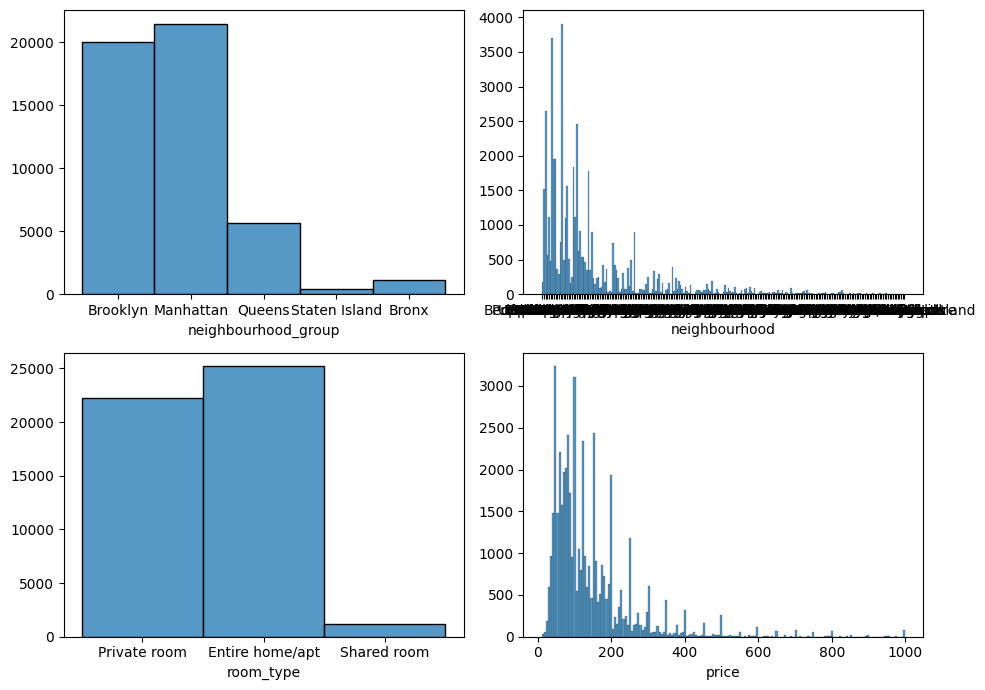

In [13]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# histograma múltiple
sns.histplot(ax = axis[0, 0], data = data, x = "neighbourhood_group").set(ylabel=None)
sns.histplot(ax = axis[0, 1], data = data, x = "neighbourhood").set(ylabel = None)
sns.histplot(ax = axis[1, 0], data = data, x = "room_type").set(ylabel = None)
sns.histplot(ax = axis[1, 1], data = data, x = "price").set(ylabel = None)

# Rotar nombres del eje x en el subplot neighbourhood

#axis[0, 1].set_xticklabels(axis[0, 1].get_xticklabels(), rotation=45)

# Ajustar el layout
plt.tight_layout()

plt.show()

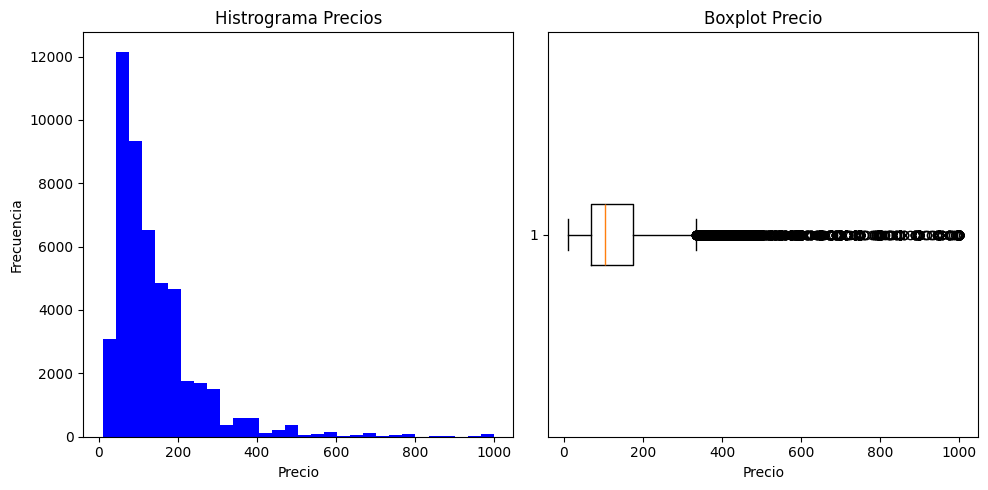

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(data['price'], bins=30, color='blue')
ax[0].set_title("Histrograma Precios")
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(data['price'], vert=False)
ax[1].set_title("Boxplot Precio")
ax[1].set_xlabel("Precio")

plt.tight_layout()
plt.show()

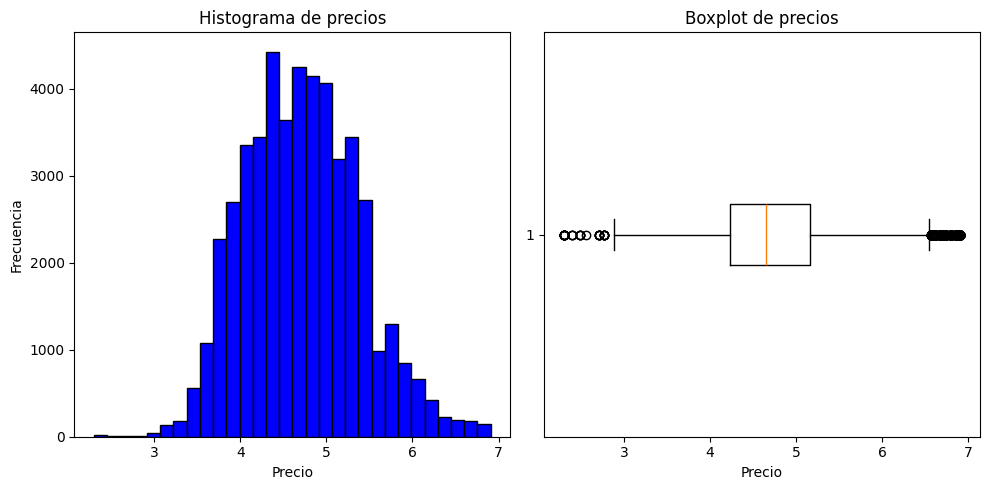

In [7]:
data['price_log'] = np.log(data.price)

# figura -subplots (histograma y boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(data['price_log'], bins=30, color='blue', edgecolor='black')
ax[0].set_title('Histograma de precios')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(data['price_log'], vert=False)
ax[1].set_title('Boxplot de precios')
ax[1].set_xlabel('Precio')

plt.tight_layout()
plt.show()

In [16]:
data.info()
data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48645 entries, 0 to 48644
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48645 non-null  object 
 1   neighbourhood                   48645 non-null  object 
 2   latitude                        48645 non-null  float64
 3   longitude                       48645 non-null  float64
 4   room_type                       48645 non-null  object 
 5   price                           48645 non-null  int64  
 6   minimum_nights                  48645 non-null  int64  
 7   calculated_host_listings_count  48645 non-null  int64  
 8   availability_365                48645 non-null  int64  
 9   price_log                       48645 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 3.7+ MB


neighbourhood_group                   5
neighbourhood                       221
latitude                          19011
longitude                         14699
room_type                             3
price                               569
minimum_nights                      108
calculated_host_listings_count       47
availability_365                    366
price_log                           569
dtype: int64

In [ ]:
# * OneHotEncoder: es una clase de scikit-learn que se utiliza para convertir variables categóricas en representaciones numéricas.
# Crea columnas de variables dummy para cada categoría única en la variable categórica original.

# * drop='first': este parámetro se utiliza para evitar la multicolinealidad (cuando dos o más variables predictoras están altamente correlacionadas entre sí).
# En la codificación one-hot, se produce cuando una columna de variables dummy se puede predecir linealmente a partir de las otras columnas de variables dummy. Al especificar drop='first', le decimos a OneHotEncoder que elimine la primera columna de variables dummy para cada característica categórica.
# Esto elimina la multicolinealidad, ya que la primera columna de variables dummy se puede deducir de las otras columnas.

# * sparse=False: eeste parámetro sparse=False se utiliza para indicar que no queremos que el resultado sea una matriz dispersa (sparse matrix)
# Por defecto, OneHotEncoder devuelve una matriz dispersa, que es eficiente en cuanto al uso de memoria cuando hay muchas categorías únicas.
# Sin embargo, en este caso, especificamos sparse=False para obtener una matriz densa, que es más fácil de manejar y manipular en el contexto del análisis y modelado de datos.

In [8]:

# Columnas a codificar con OneHotEncoder:
columnas_onehot = ['neighbourhood_group', 'room_type']

OH_encoder = OneHotEncoder()  # Inicializa el codificador OneHotEncoder

columnas_OH = OH_encoder.fit_transform(data[columnas_onehot]) # Columnas que nos interesan codificadas

nombres_columnas_OH = OH_encoder.get_feature_names_out(columnas_onehot)  # Nombre de las columnas codificadas

oh_data = pd.DataFrame(columnas_OH.toarray(), columns=nombres_columnas_OH)  # método toarray() convierte la matriz dispersa resultado de fit_transform()
                                                                            # en una matriz densa, para crear el DataFrame oh_data con la forma correcta.


# Columna a codificar con LabelEncoder:
columna_etiqueta = 'neighbourhood'

label_encoder = LabelEncoder() # Inicializa el codificador LabelEncoder

columna_etiquetada = label_encoder.fit_transform(data[columna_etiqueta])  # Aplica LabelEncoder a la columna seleccionada

# Añadir la columna codificada al DataFrame original
# (dataframe original sin las columnas colificadas + dataframe de las columnas onehot + serie columna etiquetada)
data_encoded = pd.concat([data.drop(columnas_onehot + [columna_etiqueta], axis=1),
                          oh_data, pd.Series(columna_etiquetada, name=columna_etiqueta)], axis=1)


In [9]:
# Variables independientes/dependiente
X = data_encoded.drop(['price', 'price_log'], axis=1)
y = data_encoded['price_log']

# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

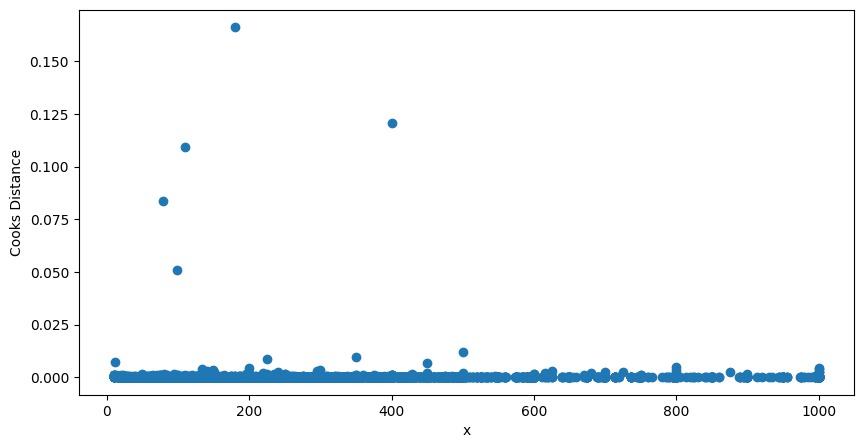

In [10]:
plt.figure(figsize=(10, 5))
plt.scatter(data.price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [11]:
np.where(cooks_distance[0]>0.05)
data.iloc[[2843, 5727, 13334, 26211, 38476,]]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,price_log
2843,Manhattan,Battery Park City,40.71239,-74.01620,Entire home/apt,400,1000,1,362,5.991465
5727,Manhattan,Greenwich Village,40.73293,-73.99782,Entire home/apt,180,1250,1,365,5.192957
13334,Manhattan,Harlem,40.82915,-73.94034,Entire home/apt,99,999,1,42,4.595120
26211,Brooklyn,Williamsburg,40.71772,-73.95059,Private room,79,999,6,249,4.369448
38476,Manhattan,Greenwich Village,40.73094,-73.99900,Shared room,110,999,1,365,4.700480


In [15]:
data_encoded.corr()
data[['minimum_nights', 'price']].corr()

,minimum_nights,price
minimum_nights,1.000000,0.019487
price,0.019487,1.000000


In [12]:
data.drop('minimum_nights', axis=1, inplace=True)
data

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,calculated_host_listings_count,availability_365,price_log
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,6,365,5.003946
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,2,355,5.416100
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,1,365,5.010635
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,194,4.488636
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,1,0,4.382027
...,...,...,...,...,...,...,...,...,...
48640,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,9,4.248495
48641,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,2,36,3.688879
48642,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,1,27,4.744932
48643,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,6,2,4.007333


In [13]:
data_encoded.drop('minimum_nights', axis=1, inplace=True)
data_encoded

,latitude,longitude,price,calculated_host_listings_count,availability_365,price_log,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood
0,40.64749,-73.97237,149,6,365,5.003946,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,108
1,40.75362,-73.98377,225,2,355,5.416100,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,127
2,40.80902,-73.94190,150,1,365,5.010635,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,94
3,40.68514,-73.95976,89,1,194,4.488636,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,41
4,40.79851,-73.94399,80,1,0,4.382027,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48640,40.67853,-73.94995,70,2,9,4.248495,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,13
48641,40.70184,-73.93317,40,2,36,3.688879,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,28
48642,40.81475,-73.94867,115,1,27,4.744932,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,94
48643,40.75751,-73.99112,55,6,2,4.007333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,95


In [14]:
# Aplicamos la función skew() a cada columna del DataFrame para calcular su sesgo:

data_encoded.apply(lambda x: x.skew())   # La función skew() calcula el sesgo (skewness) de una distribución de datos.
                                 # El sesgo es una medida de la asimetría de la distribución de datos con respecto a la media.

# Si el sesgo es cero, significa que la distribución es simétrica. 
# Si el sesgo es positivo, la distribución tiene una cola larga hacia la derecha,
# Si es negativo, la cola larga se encuentra hacia la izquierda.

latitude                              0.240598
longitude                             1.285694
price                                 2.943631
calculated_host_listings_count        7.917031
availability_365                      0.767307
price_log                             0.310558
neighbourhood_group_Bronx             6.457158
neighbourhood_group_Brooklyn          0.357657
neighbourhood_group_Manhattan         0.234683
neighbourhood_group_Queens            2.394269
neighbourhood_group_Staten Island    11.319637
room_type_Entire home/apt            -0.073523
room_type_Private room                0.169134
room_type_Shared room                 6.253575
neighbourhood                         0.258066
dtype: float64

In [ ]:
# Windsorización: técnica de preprocesamiento de datos que se utiliza para tratar los valores atípicos mediante SU modificación
#  * para que caigan dentro de un rango predefinido, en lugar de eliminarlos por completo.
# Esto ayuda a suavizar la distribución de los datos y a mitigar el efecto de los valores extremos en el análisis estadístico.

In [32]:
dtype_c = ['neighbourhood_group_Bronx',
           'neighbourhood_group_Brooklyn',
           'neighbourhood_group_Manhattan',
           'neighbourhood_group_Queens',
           'neighbourhood_group_Staten Island',
           'room_type_Entire home/apt',
           'room_type_Private room',
           'room_type_Shared room']

data_encoded[dtype_c] = data_encoded[dtype_c].astype(np.int32)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48645 entries, 0 to 48644
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   latitude                           48645 non-null  float64
 1   longitude                          48645 non-null  float64
 2   price                              48645 non-null  int64  
 3   calculated_host_listings_count     48645 non-null  int64  
 4   availability_365                   48645 non-null  int64  
 5   price_log                          48645 non-null  float64
 6   neighbourhood_group_Bronx          48645 non-null  int32  
 7   neighbourhood_group_Brooklyn       48645 non-null  int32  
 8   neighbourhood_group_Manhattan      48645 non-null  int32  
 9   neighbourhood_group_Queens         48645 non-null  int32  
 10  neighbourhood_group_Staten Island  48645 non-null  int32  
 11  room_type_Entire home/apt          48645 non-null  int

In [35]:
data_encoded.isnull().any().any()

False

In [43]:
# Seleccionamos las columnas no binarias: 
# Se identifican las columnas del DataFrame que contienen valores binarios (0 o 1) y se eliminan del DataFrame.
# La windsorización se aplica típicamente a datos numéricos continuos, y las columnas binarias no requieren windsorización.

binarias = data_encoded.columns[data_encoded.isin([0, 1]).all()]

windsorizar_datos = data_encoded.drop(binarias, axis=1)

In [44]:
# Función para calcular IQR (rango intercuartílico) y aplicar winsorización

def windsorizar_columnas(column, lower, upper):   # lower, upper: estos parámetro especifican los percentiles inferior y superior usados para calcular el rango intercuartílico (IQR)
    q1 = column.quantile(lower)  # Se calculan los percentiles lower y upper de la columna utilizando el método quantile() de Pandas.
    q3 = column.quantile(upper)
    iqr_value = q3-q1   # El IQR se calcula restando el primer cuartil (q1) del tercer cuartil (q3)

    # Calculamos los límites de windsorizacion: los valores extremos, que están más allá de 1.5 veces el IQR de los cuartiles,
    # se recorten para mitigar su influencia en el análisis estadístico
    lower_limit = q1 - 1.5 * iqr_value    # 1.5 veces el rango intercuartílico (IQR) como criterio para calcular los límites de winsorización 
    upper_limit = q3 + 1.5 * iqr_value    # es un estándar comúnmente aceptado en análisis estadístico 
    
    column = column.clip(lower=lower_limit, upper=upper_limit)  # método clip() de Pandas para recortar los valores de la columna
    return column

# Calcular el IQR y aplicar winsorización a cada columna del dataframe:

for columna in windsorizar_datos.columns:
    windsorizar_datos[columna] = windsorizar_columnas(windsorizar_datos[columna], 0.25, 0.75)


In [45]:
windsorizar_datos.apply(lambda x: x.skew())

latitude                          0.240281
longitude                         0.532499
price                             1.030948
calculated_host_listings_count    1.153987
availability_365                  0.767307
price_log                         0.279959
neighbourhood                     0.258066
dtype: float64

In [46]:
dataframe = pd.concat([windsorizar_datos, data_encoded[binarias]], axis=1)
dataframe

,latitude,longitude,price,calculated_host_listings_count,availability_365,price_log,neighbourhood,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,149,3.5,365,5.003946,108,0,1,0,0,0,0,1,0
1,40.75362,-73.98377,225,2.0,355,5.416100,127,0,0,1,0,0,1,0,0
2,40.80902,-73.94190,150,1.0,365,5.010635,94,0,0,1,0,0,0,1,0
3,40.68514,-73.95976,89,1.0,194,4.488636,41,0,1,0,0,0,1,0,0
4,40.79851,-73.94399,80,1.0,0,4.382027,61,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48640,40.67853,-73.94995,70,2.0,9,4.248495,13,0,1,0,0,0,0,1,0
48641,40.70184,-73.93317,40,2.0,36,3.688879,28,0,1,0,0,0,0,1,0
48642,40.81475,-73.94867,115,1.0,27,4.744932,94,0,0,1,0,0,1,0,0
48643,40.75751,-73.99112,55,3.5,2,4.007333,95,0,0,1,0,0,0,0,1
